## 1D Occlusion

Resources: <br>
http://www.jussihuotari.com/2018/02/01/visualizing-neural-net-using-occlusion/ <br>
https://www.analyticsvidhya.com/blog/2018/03/essentials-of-deep-learning-visualizing-convolutional-neural-networks/<br>
https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps<br>
https://arxiv.org/pdf/1311.2901.pdf <br>

In the simplest sense, in each iteration we cover a specific section of the input, and record how the output prediction probabilities change for any desired label. <br>
As the change goes higher in the negative direction, we can say that the input section associated with it has a substantial importance for the model to actually label the input with that given label. <br>
Inversely, if we cover a certain section, and the model is even more sure that the predicted label is correct (i.e. a positive change in the outcome probability), then it means that this piece has a negative impact on that particular label.

In [1]:
import numpy as np

import pickle
def writePickle(Variable, fname):
    filename = fname +".pkl"
    f = open("pickle_vars/"+filename, 'wb')
    pickle.dump(Variable, f)
    f.close()
def readPickle(fname):
    filename = "pickle_vars/"+fname +".pkl"
    f = open(filename, 'rb')
    obj = pickle.load(f)
    f.close()
    return obj

#### 0- First things first. Get your data in the same way it has been used for the models.

In [7]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import string

def load_data():
    
    data = pd.read_csv('sub_dataset.csv', header=None)
    data = data.dropna()

    x = data[2]
    x = np.array(x)

    y_artist = data[0] - 1
    y_artist = to_categorical(y_artist)
    
    y_genre = data[1] - 1
    y_genre = to_categorical(y_genre)
    
    return (x, y_artist, y_genre)

x, y_artist, y_genre = load_data()

# Shuffle data
np.random.seed(23) # !!!!!! use the same seed value in all dataset split versions !!!!!!
shuffle_indices = np.random.permutation(np.arange(len(y_artist))) 
# shuffle all inputs with the same indices
x_shuffled = x[shuffle_indices]
y_artist_shuffled = y_artist[shuffle_indices]

# form count dictionaries for both artist and genre labels
# first, artist labels
artist_label_count_dict = dict()
for i in range(120):
    artist_label_count_dict[i] = 0
# then also for genre labels
genre_label_count_dict = dict()
for i in range(12):
    genre_label_count_dict[i] = 0
    
'''Now, we'll go through the data examples one by one. If each artist label occurs less than 80 times, the sample 
will belong to the training set; occurances between 81th and 90th times will go to the validation set and the 
occurances between 91th and 100th times (last 10 occurances) will go to the test set.
For genre labels, any genre label occuring less than 800 times will go to the training set; occurances between 801th and 
900th times will go to the validation set and the occurances between 901th and 1000th times (last 100 occurances) will 
go to the test set.'''

# create training, validation and test sets with equal distributions of artists and genres
x_tr_artist, x_val_artist, x_te_artist = list(), list(), list()
y_tr_artist, y_val_artist, y_te_artist = list(), list(), list()

for sample, art_label in zip(x_shuffled, y_artist_shuffled):
    artist_label_index = np.argmax(art_label, axis=-1)

    # for artist labels
    if artist_label_count_dict[artist_label_index] < 80:
        x_tr_artist.append(sample)
        y_tr_artist.append(art_label)
    elif 80 <= artist_label_count_dict[artist_label_index] < 90:
        x_val_artist.append(sample)
        y_val_artist.append(art_label)
    elif 90 <= artist_label_count_dict[artist_label_index] < 100:
        x_te_artist.append(sample)
        y_te_artist.append(art_label)
    else:
        print("There is an error with artist counts!")
    artist_label_count_dict[artist_label_index] += 1
             
# turn the output datasets in np arrays
x_tr_pho_artist = np.array(x_tr_artist)
x_val_pho_artist = np.array(x_val_artist)
x_te_pho_artist = np.array(x_te_artist)

y_tr_pho_artist = np.array(y_tr_artist)
y_val_pho_artist = np.array(y_val_artist)
y_te_pho_artist = np.array(y_te_artist)

#### 1- Prepare useful variables

In [6]:
# get your rhyme model predictions file with the best predictions
p_file_name = "Predictions_rhyme_artist_B100E50ES10max_length:_5913vocab_size:_89kernel_sizes:_[11, 9, 7, 5]kernelseach:_10029.12.2020.15:03:22"

# get test set labels, your predicted labels, the dictionary to decode label ids, and training and test sets for occluded predictions
test_labels = readPickle("rhyme/y_te_artist") # artist labels for the rhyme model (test)
train_labels = readPickle("rhyme/y_tr_artist") # artist labels for the rhyme model (train)
predictions = readPickle("predictions/"+p_file_name) # just use the file name
artist_label_dictionary = readPickle("id2artist")
test_inputs = readPickle("rhyme/x_te_artist")
train_inputs = readPickle("rhyme/x_tr_artist")

# load the equivalent model stored
from tensorflow import keras
model = keras.models.load_model("saved_models/rhyme_artist_B100E50ES10max_length:_5913vocab_size:_89kernel_sizes:_[11, 9, 7, 5]kernelseach:_10029.12.2020.15:03:22.keras")


# finally, download your vocabulary. with this, we will be able to convert phoneme ids to actual phonemes
vocabulary = readPickle("rhyme/phoneme_vocabulary_Embeddings")
phoneme_encoder = {i+1 : pho for i, pho in enumerate(vocabulary)}
phoneme_decoder = {pho : i+1 for i, pho in enumerate(vocabulary)}
phoneme_encoder[0] = "PAD" # add also one for padding
phoneme_decoder["PAD"] = 0

print(phoneme_encoder)

{1: 'S', 2: 'AW1', 3: 'UW0', 4: 'IH0', 5: 'ZH', 6: 'UH2', 7: 'TH', 8: 'OW', 9: 'HH', 10: 'AE1', 11: 'EH2', 12: 'AH', 13: 'NG', 14: 'IY1', 15: 'K', 16: 'R', 17: 'IY0', 18: 'V', 19: 'AO', 20: 'UH0', 21: 'EH0', 22: 'OW0', 23: 'AE0', 24: 'M', 25: 'SH', 26: 'AY2', 27: 'OW1', 28: 'T', 29: 'AH2', 30: 'ER0', 31: 'DH', 32: 'IH2', 33: 'OY', 34: 'AW', 35: 'UH', 36: 'AH1', 37: 'AY1', 38: 'AH0', 39: 'IX', 40: 'Z', 41: 'AO1', 42: 'UH1', 43: 'AA', 44: 'N', 45: 'UW1', 46: 'OY1', 47: 'TS', 48: 'ER1', 49: 'AA1', 50: 'B', 51: 'D', 52: 'IY2', 53: 'CH', 54: 'AA2', 55: 'EY2', 56: 'W', 57: 'AW2', 58: 'UW2', 59: 'UW', 60: 'AY0', 61: 'OW2', 62: 'EY1', 63: 'EH1', 64: 'AO0', 65: 'EY', 66: 'G', 67: 'EH', 68: 'IH', 69: 'Y', 70: 'IH1', 71: 'OY0', 72: 'ER', 73: 'AE', 74: 'OY2', 75: 'UNK', 76: 'AY', 77: 'AA0', 78: 'AO2', 79: 'EY0', 80: 'L', 81: 'AE2', 82: 'P', 83: 'F', 84: 'JH', 85: 'IY', 86: 'AW0', 87: '±ã¬³', 88: 'ER2', 0: 'PAD'}


#### 2- Find out what is interesting about your predictions. Which artists have been detected with a high rate?


In [8]:
# get all the artist labels for lyrics correctly predicted
corrects = [artist_label_dictionary[a+1] for a,b in zip(np.argmax(predictions, axis=-1), np.argmax(test_labels, axis=-1)) if a == b]
# check whether your accuracy holds with the model accuracy
print("Overall accuracy of the model:",len(corrects)/len(test_labels))
# now, sort the list by the number of occurances. see who was predicted with extreme accuracy
from collections import Counter
sorted_corrects = Counter(corrects)
sorted_corrects.most_common(10) # show the best 10
overall_results = dict()
for artist in artist_label_dictionary.values():
    try:
        overall_results[artist] = sorted_corrects[artist]
    except:
        overall_results[artist] = 0
print(len(overall_results), overall_results)

Overall accuracy of the model: 0.15333333333333332
120 {'50 Cent': 7, 'Acappella': 8, 'Al Jarreau': 1, 'Alicia Keys': 0, 'Amorphis': 3, 'Annihilator': 2, 'ApologetiX': 5, 'Arlo Guthrie': 6, 'Art Rush': 0, 'Asia': 0, 'Avril Lavigne': 0, 'Bad Religion': 1, 'Big Head Todd And The Monsters': 1, 'Bill Nelson': 2, 'Billie Holiday': 1, 'Björk': 0, 'Bobby Darin': 1, 'Bobby O': 1, 'Brave Combo': 1, 'Brian McKnight': 0, 'Bride': 0, 'Bruce Cockburn': 0, 'Bruce Springsteen': 1, 'Buddy Guy': 1, 'Cab Calloway': 0, 'Canibus': 6, 'Carly Simon': 4, 'Chris Brown': 0, 'Chris Isaak': 2, 'Ciara': 3, 'Colin James': 0, 'Connie Francis': 1, 'D.R.I.': 0, "Daniel O'Donnell": 0, 'David Allan Coe': 2, 'Dean Martin': 1, 'Devendra Banhart': 1, 'Diana Krall': 0, 'Diana Ross': 1, 'Donny Osmond': 0, 'Dwight Yoakam': 1, 'Ella Fitzgerald': 3, 'Elvis Presley': 0, 'Etta James': 0, 'Ferlin Husky': 1, 'Fred Hammond': 3, 'Freddie Hart': 2, 'Gary Moore': 1, 'George Strait': 1, 'Gloria Estefan': 1, 'Good Riddance': 3, 'Gordon 

We see that there are really well-predicted artists (up to 8 correct predictions out 10). Also there are many others that haven't been predicted correctly even once. Let's get a better analysis.

#### 3- Create a dataframe that shows which artist
**This dataframe consists of data for almost all the test artist instances (1191 out of 1200). We have implemented a script (6.2_Occlusion_Operation_ArtistLabels.py) to get the 3-window size occlusion results for any given song. The result is stored under a huge variable (occlusion_outputs.pkl), which will be read here, to reflect important information like what were the occlusion probabilities for a given song, what is the best guess, what is the next best guess, etc.**

In [9]:
import pandas as pd
# create artist_name --> genre dict
sub = readPickle("sub_dataset")
artist_name2genre = dict()
for entry in sub.values():
    artist_name2genre[entry[0]] = entry[1]

# read the occlusion change dictionaries
o_o = readPickle("occlusion_outputs")
# add the actual label to the dict
for k, v in o_o.items():
    o_o[k].append(artist_label_dictionary[np.argmax(test_labels, axis=-1)[k]+1])
    o_o[k].append(v[4]-v[0].count(0)) # add actual song length = length - number of padding in the end
# convert the dict to dataframe
analysis = pd.DataFrame.from_dict(o_o, orient ='index')
# delete some unnecessary columns
del analysis[3]
del analysis[4]

# show all rows in the dataframe
pd.set_option('display.max_rows', analysis.shape[0]+1)

# change column names
analysis.columns = ['Change List', 'Most Neg. Effect', 'Most Pos. Effect', "Best Guess", "Best G. Prob.", "Next Guess", "Next G. Prob.", "Actual", "Actual Length"]
# move some columns to desired places
analysis = analysis.reindex(columns=['Change List', 'Most Neg. Effect', 'Most Pos. Effect', "Actual Length", "Actual", "Best Guess", "Best G. Prob.", "Next Guess", "Next G. Prob."])
# sort the dataframe
analysis = analysis.sort_values(by=['Actual'], ascending=True)
# add genre labels for each artist
actual_list = analysis['Actual'].tolist()
best_guess_list = analysis['Best Guess'].tolist()
next_guess_list = analysis['Next Guess'].tolist()
actual2genre, best2genre, next2genre = dict(), dict(), dict()
for actual, best, next_ in zip(actual_list, best_guess_list, next_guess_list):
    actual2genre[actual] = artist_name2genre[actual]
    best2genre[best] = artist_name2genre[best]
    next2genre[next_] = artist_name2genre[next_]
analysis["Actual Genre"] = analysis['Actual'].map(actual2genre)
analysis["Best Genre"] = analysis['Best Guess'].map(best2genre)
analysis["Next Genre"] = analysis['Next Guess'].map(next2genre)

analysis = analysis.sort_values(by=['Best Guess'], ascending=True)

analysis



Change List  Most Neg. Effect  \
1190  [0.0, -0.0017158687, -0.003445387, 0.000873357...          0.065413   
1158  [0.0, 0.0, 0.0, 0.0, 0.0023434162, 0.0, 1.5616...          0.051755   
433   [0.0, 0.0012241006, -0.0005131811, 0.005067408...          0.043099   
642   [0.0, -0.0061448067, -0.0024427027, 0.00297446...          0.057708   
9     [-0.0010837168, -0.00036408007, -0.001299113, ...          0.038277   
255   [-0.00094436854, -0.0003042817, -1.861155e-05,...          0.061803   
225   [0.0, -0.007055208, 0.0011314899, 0.0001759082...          0.072181   
83    [0.0, 0.0, 0.0, 0.0016651899, -0.01011762, -0....          0.067100   
1180  [0.0, 0.0, 0.0, -0.006458223, -0.009307861, -0...          0.073243   
727   [0.0, 0.007051617, -0.005033374, -0.0014311224...          0.048898   
590   [-0.0043275952, 0.0, 0.0012212396, -0.00072583...          0.096181   
270   [0.0025681257, -0.0005322099, -0.0023926497, 0...          0.057339   
710   [-0.0020607412, -0.001523912, 0.0022132397, 0....          0.094556   
424   [0.0, 0.0, -0.00079220533, -0.00311175, -0.000...          0.102115   
1184  [-5.814433e-05, -5.814433e-05, -0.006584972, -...          0.050024   
659   [-0.008657426, 0.03474413, 0.02181296, -0.0073...          0.053513   
75    [0.0, 0.0012150407, 1.3113022e-05, 0.001483202...          0.071026   
51    [0.0, 0.0, 0.0, 0.007781744, 0.0, 0.0, -0.0010...          0.061071   
559   [-0.00035341084, -0.0024516732, 0.011339918, 0...          0.051016   
375   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0024676025, 0...          0.053160   
543   [-0.0012707114, -0.00032442808, -0.0053890944,...          0.105122   
30    [0.0010652542, 0.0025494099, 9.953976e-06, -0....          0.037779   
713   [0.0, -0.0042303056, -0.003079012, 0.002476990...          0.059918   
478   [-0.006558746, 0.003444761, 0.0064368546, 0.00...          0.049185   
1183  [0.0, 0.0018726587, -0.004671216, -0.002952933...          0.075637   
711   [0.0, 0.0, 0.0, 0.0, 1.1920929e-07, 1.1920929e...          0.000002   
759   [0.0, 3.5762787e-07, 8.34465e-07, 2.3841858e-0...          0.000013   
217   [0.0, -2.3841858e-07, 0.0, -3.5762787e-07, -2....          0.000005   
351   [0.0, 0.0, 0.0, 5.9604645e-07, 2.3841858e-07, ...          0.000002   
605   [-5.6028366e-06, -7.033348e-06, 0.0, 3.2186508...          0.000046   
102   [0.0, 0.0, -1.1920929e-07, -1.7881393e-06, -2....          0.000010   
995   [0.0, -4.7683716e-07, -3.5762787e-07, 0.0, -3....          0.000004   
391   [-1.1920929e-07, -1.1920929e-07, -1.1920929e-0...          0.000001   
177   [0.00013893843, 0.0018721968, 0.003374964, 0.0...          0.057788   
17    [-0.0008974895, -0.00019444525, 0.0030866787, ...          0.051742   
950   [0.0, 0.00032043457, 1.2472272e-05, 0.00056640...          0.030495   
752   [0.0, 0.0013272464, -0.0006364733, 0.004637032...          0.074434   
884   [0.0, 0.0, 0.0, 0.002087891, 0.00511007, 0.001...          0.047561   
169   [0.0, 0.0006181747, 0.00038713962, -0.00096072...          0.027622   
525   [0.0005175173, 0.000556536, -0.0016801432, -0....          0.053140   
924   [0.0013529956, 0.0059044957, 0.00019165874, 0....          0.049749   
874   [0.0, 0.0009559095, -0.0018415898, -0.00373238...          0.029519   
386   [0.004014164, 0.007828765, -0.001533106, -0.00...          0.028817   
793   [0.0007544346, 0.00015579164, -0.00088877603, ...          0.037404   
646   [2.6203692e-05, -0.002707988, 0.0, 0.0, -7.025...          0.027391   
107   [0.00020659715, 0.0, -0.00042214245, -0.004733...          0.041809   
430   [0.0038014352, 0.0016413927, -0.009427525, -0....          0.052111   
1164  [0.0, 0.0, 0.0, 3.774464e-05, 0.0019164309, -0...          0.021401   
37    [-0.006072752, -0.00075054914, 0.0031095669, -...          0.026561   
1052  [0.0, -0.005181402, 0.0017822087, 0.0, 0.00065...          0.034755   
738   [0.0, 0.0013384521, -0.0013585091, -0.00061400...          0.050315   
826   [0.003925979, -0.00062583387, -0.0

In [10]:
analysis.shape

(1191, 12)

#### 4- Write several functions that convert your occlusion probabilities into understandable color maps.
There will be there versions:
- the first one writes all the phonemes in the song to a n x n grid. the corresponding probability changes are reflected in each grid.
- the second and third versions are very similar (one of them also shows lyrics, one of them does not). they use a grid that is of dimension h x w. h corresponds to the song length (in terms of number of lines) and w corresponds to the max line length. so the lyrics are represented line by line (and left padded). each grid shows the effect of the corresponding phoneme particle on the final prrediction.

In [12]:
def occluder_heatmap(change_list, input_selection, scope, input_index):
    
    # 0. check the scope value. we want a scope value as either 'full' or 'partial'. Full version also depicts
    # the padding area, by as a trade off it is exceptionally large. Partial version removes the padding area.
    if scope not in ["full", "partial"]:
        raise ValueError("The scope value must eiter be 'full' or 'partial'")
    
    # 1. convert the input from ids to real valued strings 
    input_converted = list()
    for item in input_selection:
        input_converted.append(phoneme_encoder[item])
        
    # 2. create a dataframe out of probabilities, and a dummy dataframe for corresponding lyric string pieces
    import math
    if scope == 'full':
        size = math.ceil(math.sqrt(len(input_converted)))
    elif scope == 'partial':
        pad_index = np.where(input_selection == 0) # find the first index that padding starts
        size = math.ceil(math.sqrt(pad_index[0][0]+1))
        
    
    import pandas as pd
    
    last = change_list[-1]
    while len(change_list) < int(size*size):
        change_list.append(last)
    values = np.array(change_list[:min(size*size,len(change_list))])
    values = values.reshape(size, size)
    value_df = pd.DataFrame(values, index=range(size), columns=range(size))
    
    dummy_data = np.array([np.arange(size)]*size)
    text_df = pd.DataFrame(dummy_data, index=range(size), columns=range(size))
    # fill in the text
    for row in range(size):
        for column in range(size):
            try:
                text_df[column][row] = input_converted[(row*size)+column]
            except:
                text_df[column][row] = 'NaN'
    
    # 4. plot everything in seaborn
    import seaborn as sns
    sns.set(rc={'figure.figsize':(60,60)})
    sns.set(font_scale=3.5)
    ax = sns.heatmap(value_df, annot=text_df, cmap="RdBu",center=0, fmt='', linewidths=.5, annot_kws={"size": 40}, cbar_kws={'orientation': 'horizontal'})
    ax.tick_params(bottom=False)
    figure = ax.get_figure()
    name = 'occlusion_graphs/artist_label_'+str(input_index)+'_'+scope+'.png'
    figure.savefig(name, dpi=100)

def occluder_heatmap_wo_lyrics(change_list, input_selection, scope, input_index, splits):
    
    # 0. check the scope value. we want a scope value as either 'full' or 'partial'. Full version also depicts
    # the padding area, by as a trade off it is exceptionally large. Partial version removes the padding area.
    if scope not in ["full", "partial"]:
        raise ValueError("The scope value must eiter be 'full' or 'partial'")
    
    # 1. convert the input from ids to real valued strings 
    input_converted = list()
    for item in input_selection:
        input_converted.append(phoneme_encoder[item])
        
    # 2. find the longest line in the entry & the length of the song & list of lengths of pieces in all lines
    max_len = max([len(i) for i in splits])
    song_length = len(splits)
    len_pieces = [len(i) for i in splits]
    
    # 3. prepare the values and written content for the heatmap
    

    probs = list()
    phonemes = list()
    actuals = list()
    old_length = 0
    for length, pieces in zip(len_pieces, splits):
        
        #print(length,pieces)
        line_prob_values = list()
        line_phonemes = list()
        padding_length = max_len - length
        for i in range(padding_length):
            line_prob_values.append(0)
            line_phonemes.append('PAD')

        for i in range(old_length,old_length+length):
            line_prob_values.append(change_list[i])
            line_phonemes.append(input_converted[i])
        old_length += length
        probs.append(line_prob_values)
        phonemes.append(line_phonemes)
    

    dummy_data = np.array([np.arange(max_len)]*(song_length))
    text_df = pd.DataFrame(dummy_data, index=range((song_length)), columns=range(max_len))
    values_df = pd.DataFrame(dummy_data, index=range((song_length)), columns=range(max_len))
    
    # create the text
    values = []
    texts = []
    for i,j in zip(probs,phonemes):
        values.append(i)
        texts.append(j)

    # update value and text dataframes
    for i, entry in enumerate(values):
        values_df.loc[i] = entry
    for i, entry in enumerate(texts):
        text_df.loc[i] = entry

    
    # 4. plot everything in seaborn
    import seaborn as sns
    sns.set(rc={'figure.figsize':(60,60)})
    sns.set(font_scale=3.5)
    ax = sns.heatmap(values_df, annot=text_df, cmap="RdBu",center=0, fmt='', linewidths=.5, annot_kws={"size": 40, 'rotation': 45}, cbar_kws={'orientation': 'horizontal'})
    ax.tick_params(bottom=False)
    figure = ax.get_figure()
    name = 'occlusion_graphs/artist_label_'+str(input_index)+'_'+scope+'.png'
    figure.savefig(name, dpi=100)

def occluder_heatmap_w_lyrics(change_list, input_selection, scope, input_index, splits):
    
    # 0. check the scope value. we want a scope value as either 'full' or 'partial'. Full version also depicts
    # the padding area, by as a trade off it is exceptionally large. Partial version removes the padding area.
    if scope not in ["full", "partial"]:
        raise ValueError("The scope value must eiter be 'full' or 'partial'")
    
    # 1. convert the input from ids to real valued strings 
    input_converted = list()
    for item in input_selection:
        input_converted.append(phoneme_encoder[item])
        
    # 2. find the longest line in the entry & the length of the song & list of lengths of pieces in all lines
    max_len = max([len(i) for i in splits])
    song_length = len(splits)
    len_pieces = [len(i) for i in splits]
    
    # 3. prepare the values and written content for the heatmap
    

    probs = list()
    phonemes = list()
    actuals = list()
    old_length = 0
    for length, pieces in zip(len_pieces, splits):
        
        #print(length,pieces)
        line_prob_values = list()
        line_phonemes = list()
        line_actuals = list()
        padding_length = max_len - length
        for i in range(padding_length):
            line_prob_values.append(0)
            line_actuals.append(" ")
            line_phonemes.append('PAD')
        for i in range(padding_length,padding_length + length):
            #line_prob_values.append(change_list[length+i-padding_length+cum_length])
            #line_phonemes.append(input_converted[length+i-padding_length+cum_length])
            line_actuals.append(pieces[i-padding_length])
        for i in range(old_length,old_length+length):
            line_prob_values.append(change_list[i])
            line_phonemes.append(input_converted[i])
        old_length += length
        probs.append(line_prob_values)
        phonemes.append(line_phonemes)
        actuals.append(line_actuals)
    

    dummy_data = np.array([np.arange(max_len)]*(song_length*2))
    text_df = pd.DataFrame(dummy_data, index=range((song_length*2)), columns=range(max_len))
    values_df = pd.DataFrame(dummy_data, index=range((song_length*2)), columns=range(max_len))
    
    # create the text
    values = []
    texts = []
    for i,j,k in zip(probs,phonemes,actuals):
        values.append(i)
        values.append([0]*max_len)
        texts.append(j)
        texts.append(k)

    # update value and text dataframes
    for i, entry in enumerate(values):
        values_df.loc[i] = entry
    for i, entry in enumerate(texts):
        text_df.loc[i] = entry

    
    # 4. plot everything in seaborn
    import seaborn as sns
    sns.set(rc={'figure.figsize':(60,60)})
    sns.set(font_scale=2.0)
    ax = sns.heatmap(values_df, annot=text_df, cmap="RdBu",center=0, fmt='', linewidths=.5, annot_kws={"size": 40, 'rotation': 45}, cbar_kws={'orientation': 'horizontal'})
    figure = ax.get_figure()
    name = 'occlusion_graphs/artist_label_'+str(input_index)+'_'+scope+'.png'
    figure.savefig(name, dpi=400)

**Some examples without left padding**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


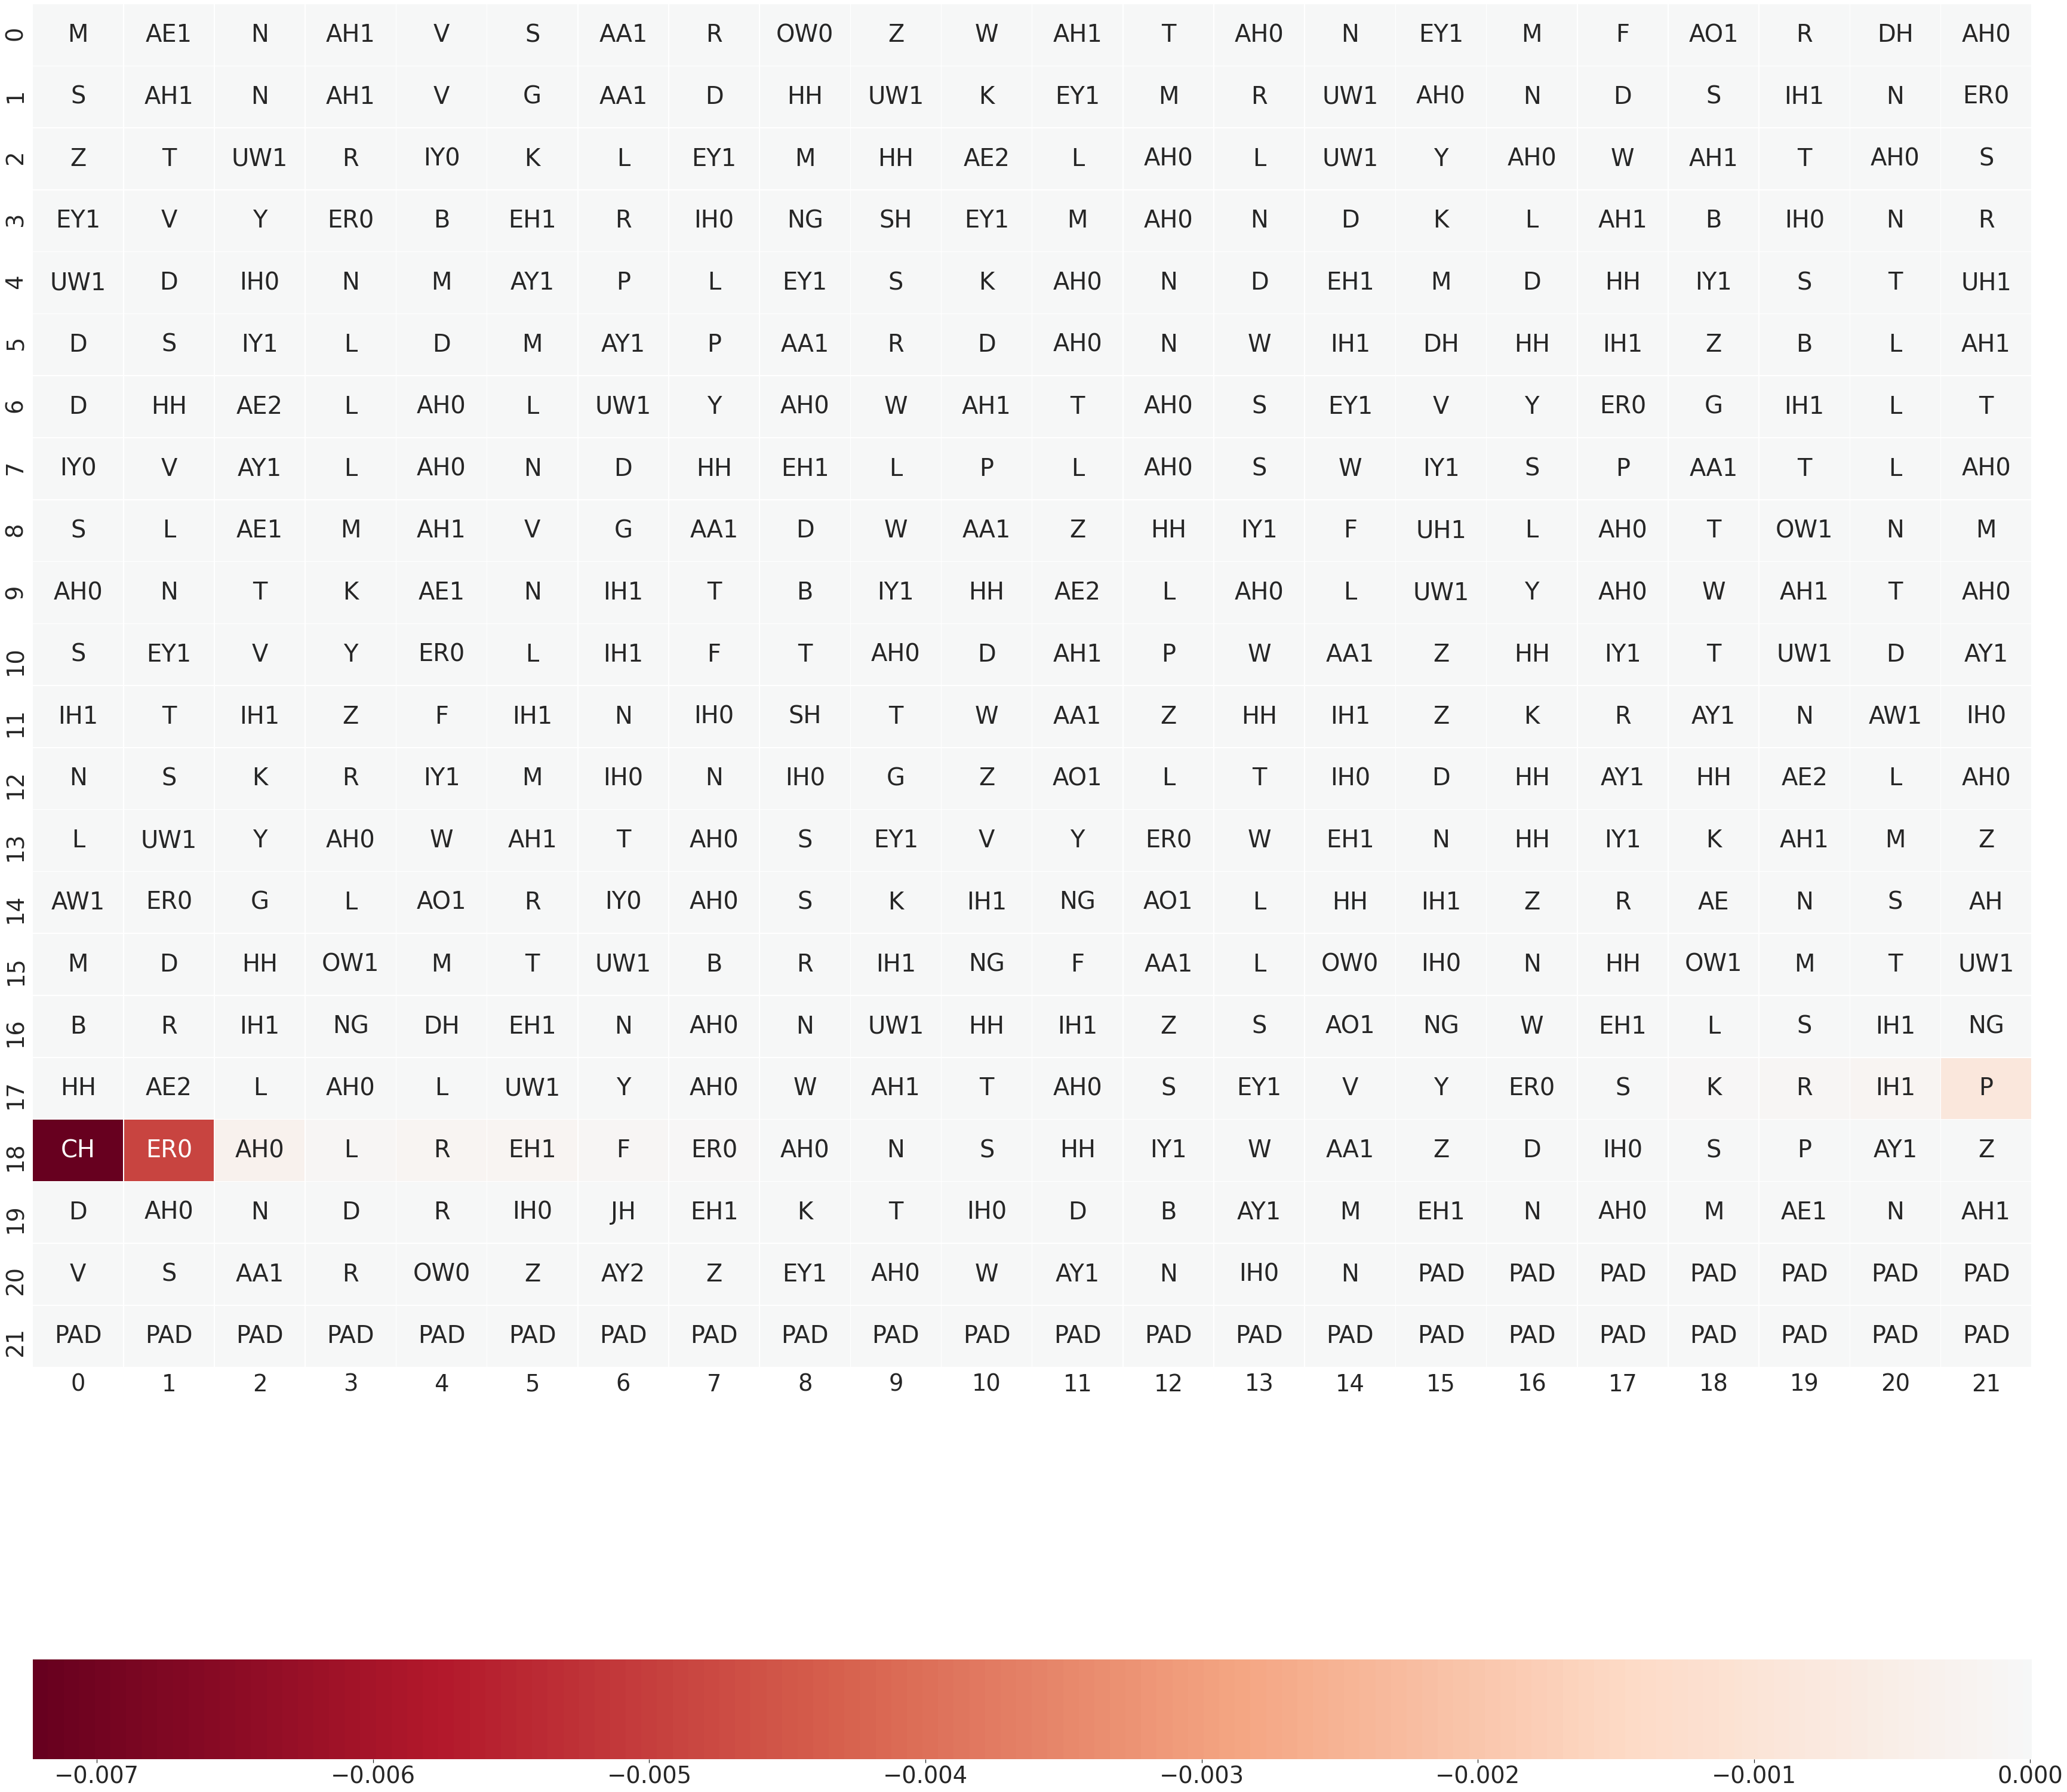

In [347]:
occluder_heatmap(analysis.loc[217,'Change List'], test_inputs[217], 'partial', 217)

In [328]:
print([i for i in x_te_pho_artist[54].split("\n")])

['Let me start off by saying', "Baby don't go both ways", "She don't mind flirting and playing", "At least that's what she say", 'Got off in the spot', "And I'm tripping", "She knows baby girl's first name", "Could it be something I'm missing", 'Or am I just part of the game', 'Whoa whoa', 'She getting more change than the players', 'Whoa whoa', 'She putting fingers up to the haters', 'Whoa whoa', 'Way she do it it look so good', "Like I said she don't go both ways", 'But this is making me wish she would', '', 'My girl like them girls', "It's all right it's okay", 'My girl like them girls', "It's all right it's okay", 'So I let her let her do her thing', 'I even let her make it rain', 'My girl like them girls', 'She like them girls', 'Oh yeah', '', "Didn't know that she liked them girls", "Didn't know she...", '', 'Number one fantasy on my list', 'I even did it once in my dream', 'Ooh that damn Minaj', 'Could it really be happening', "Baby how you gon' tease me", 'Tucking dollars all b

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


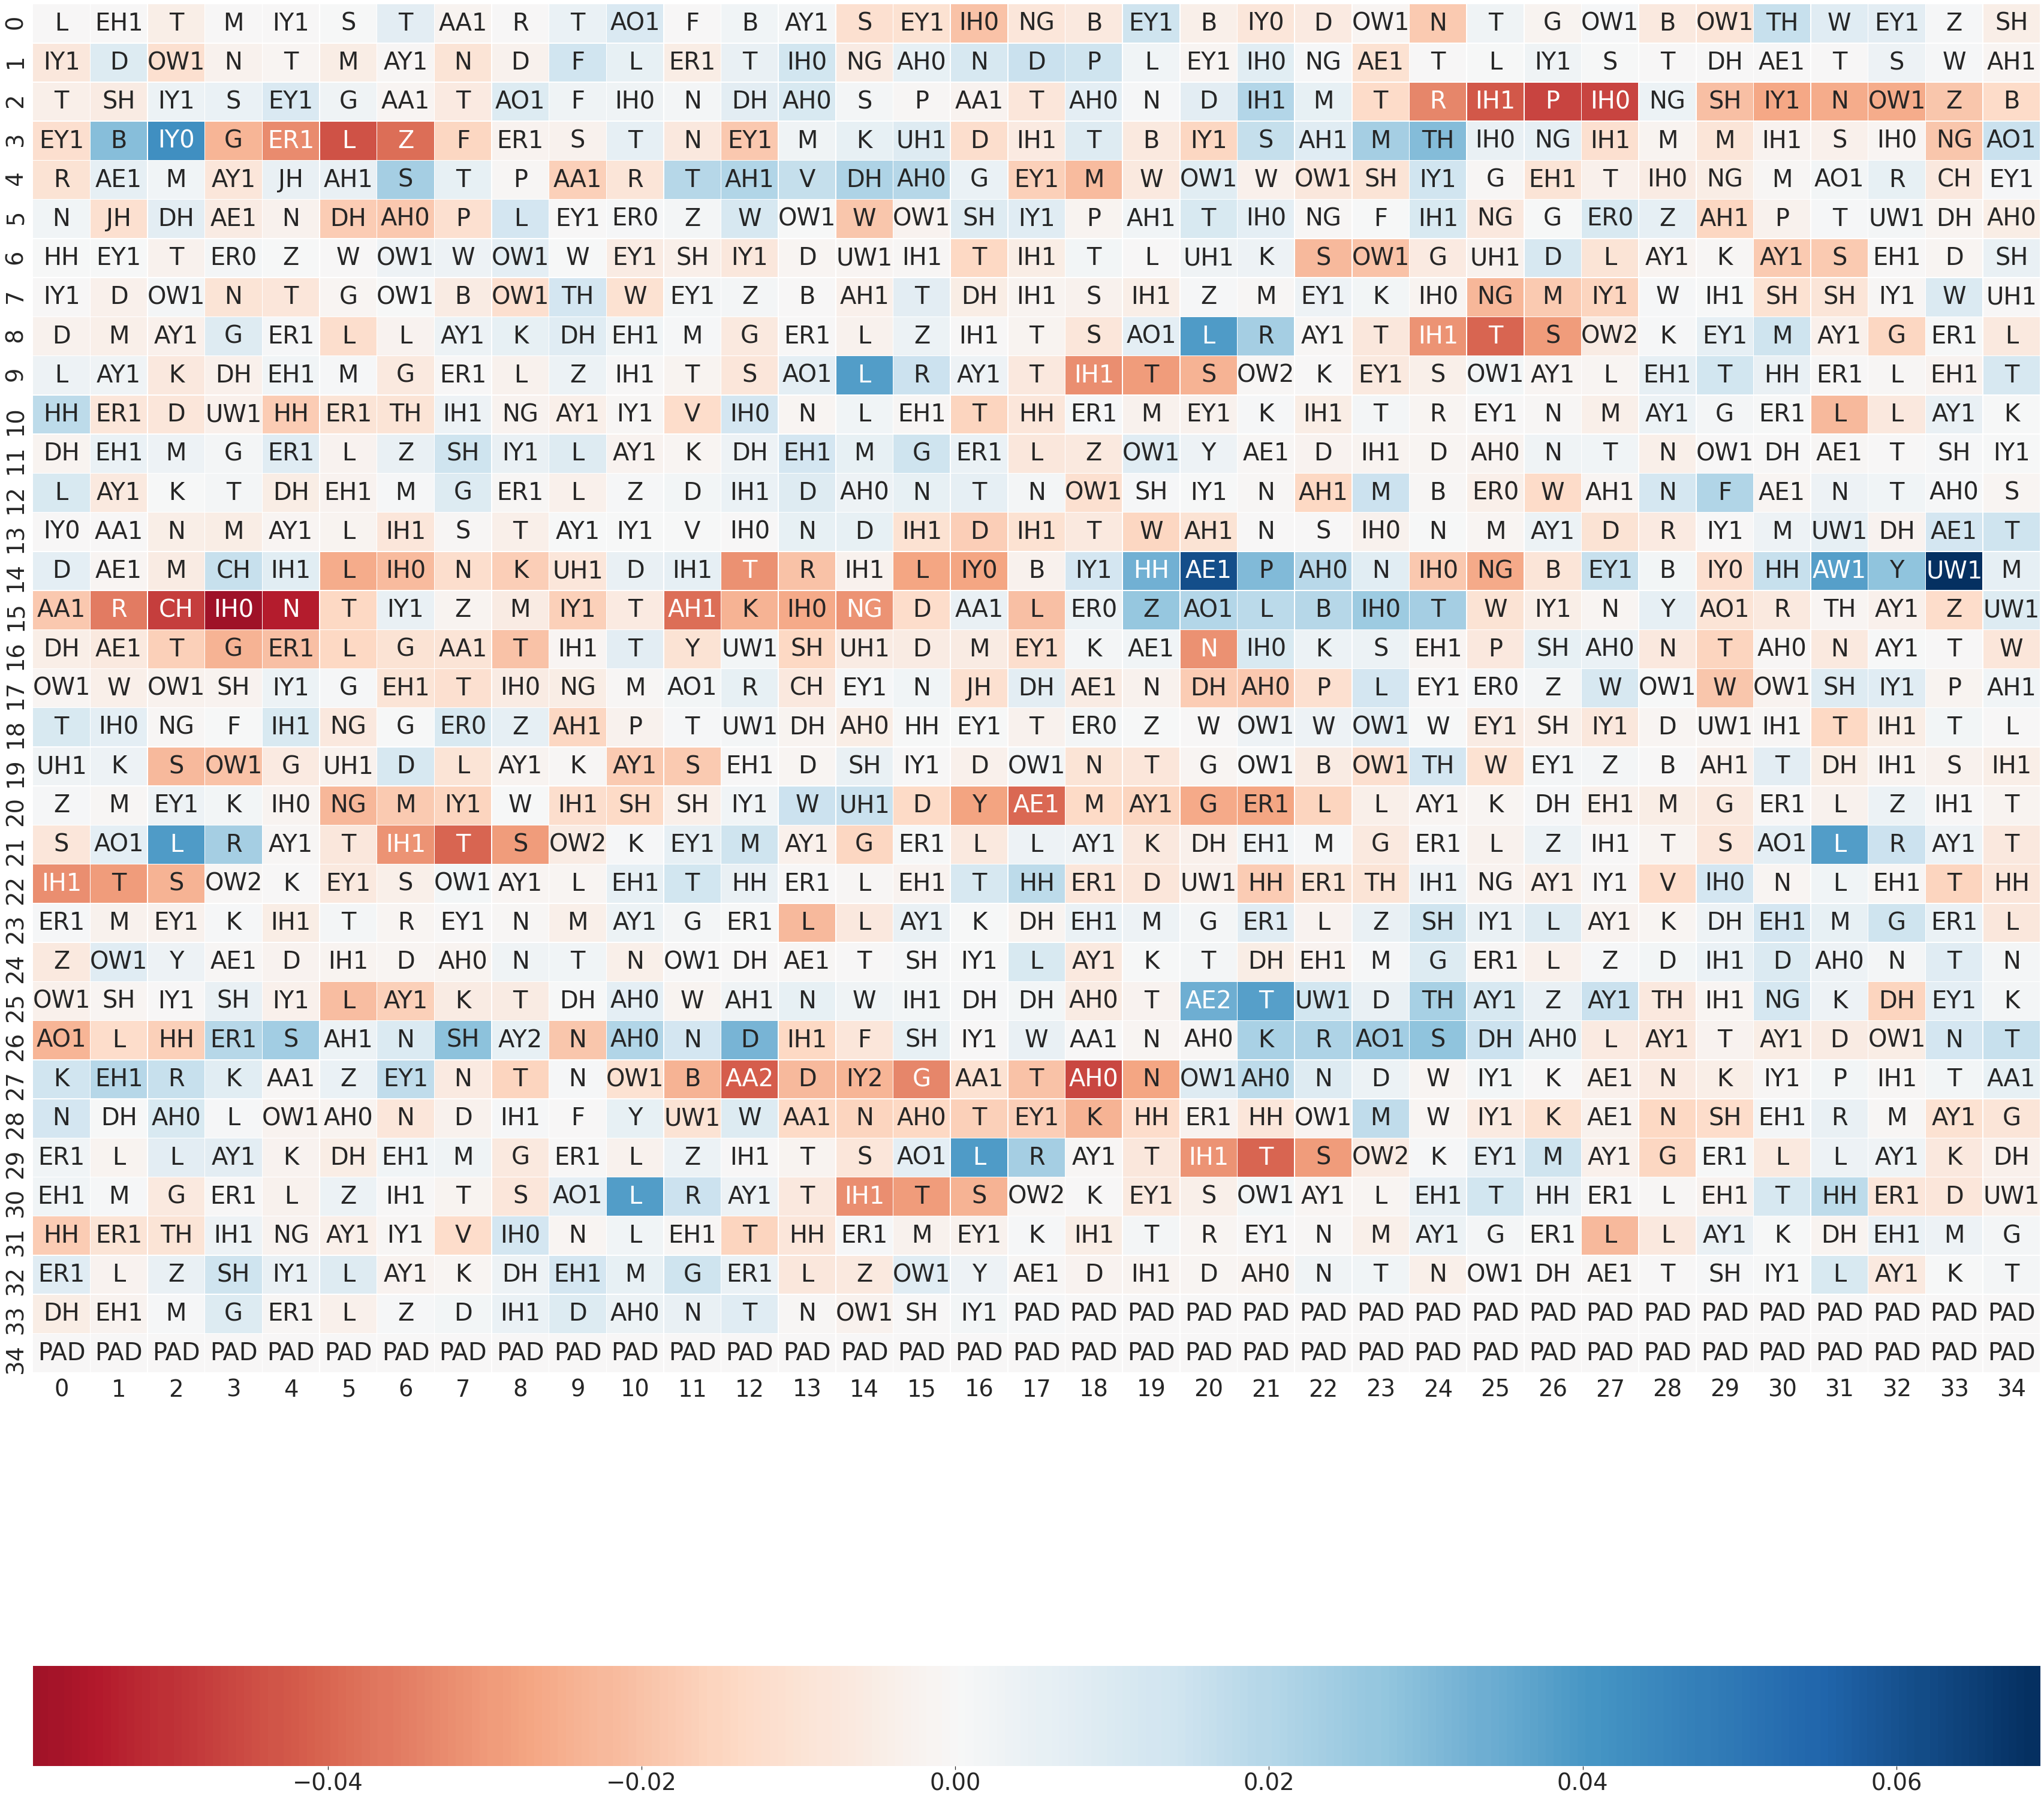

In [343]:
occluder_heatmap(analysis.loc[54,'Change List'], test_inputs[54], 'partial', 54)

In [331]:
print([i for i in x_te_pho_artist[305].split("\n")])

['I see you standing there', 'So fly from skin to hair', "Like you don't want nobody close to you", "Maybe I'm not your style", 'Too street up, just to wild', 'But let me show you what a guy can do', '', "So if I'm not too ghetto for you", "I'd like to get to know you", 'Ooh girl I really wanna grind with chu', "So if I'm not too ghetto for you", "Got things I'd like to show you", 'Ooh girl I really wanna (ah) with chu', '', 'I like the way you walk (walk)', 'And your dirty talk (dirty talk)', 'Girl let me bring out the freak in you', "I'll take you to my crib", 'Cook up some (?) ribs', 'Do things you never thought a guy can do', '', "You don't have to hide me from your kids, your dad your moms", "I'll put on a suit, show up with flowers or fruit", "So girl, don't chu get into panic", "'Cause I can be romantic", 'But if something goes down', 'Trust me I can put it down, So', '', "So if I'm not too ghetto for you", "I'd like to get to know you", 'Ooh girl I really wanna grind with chu',

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


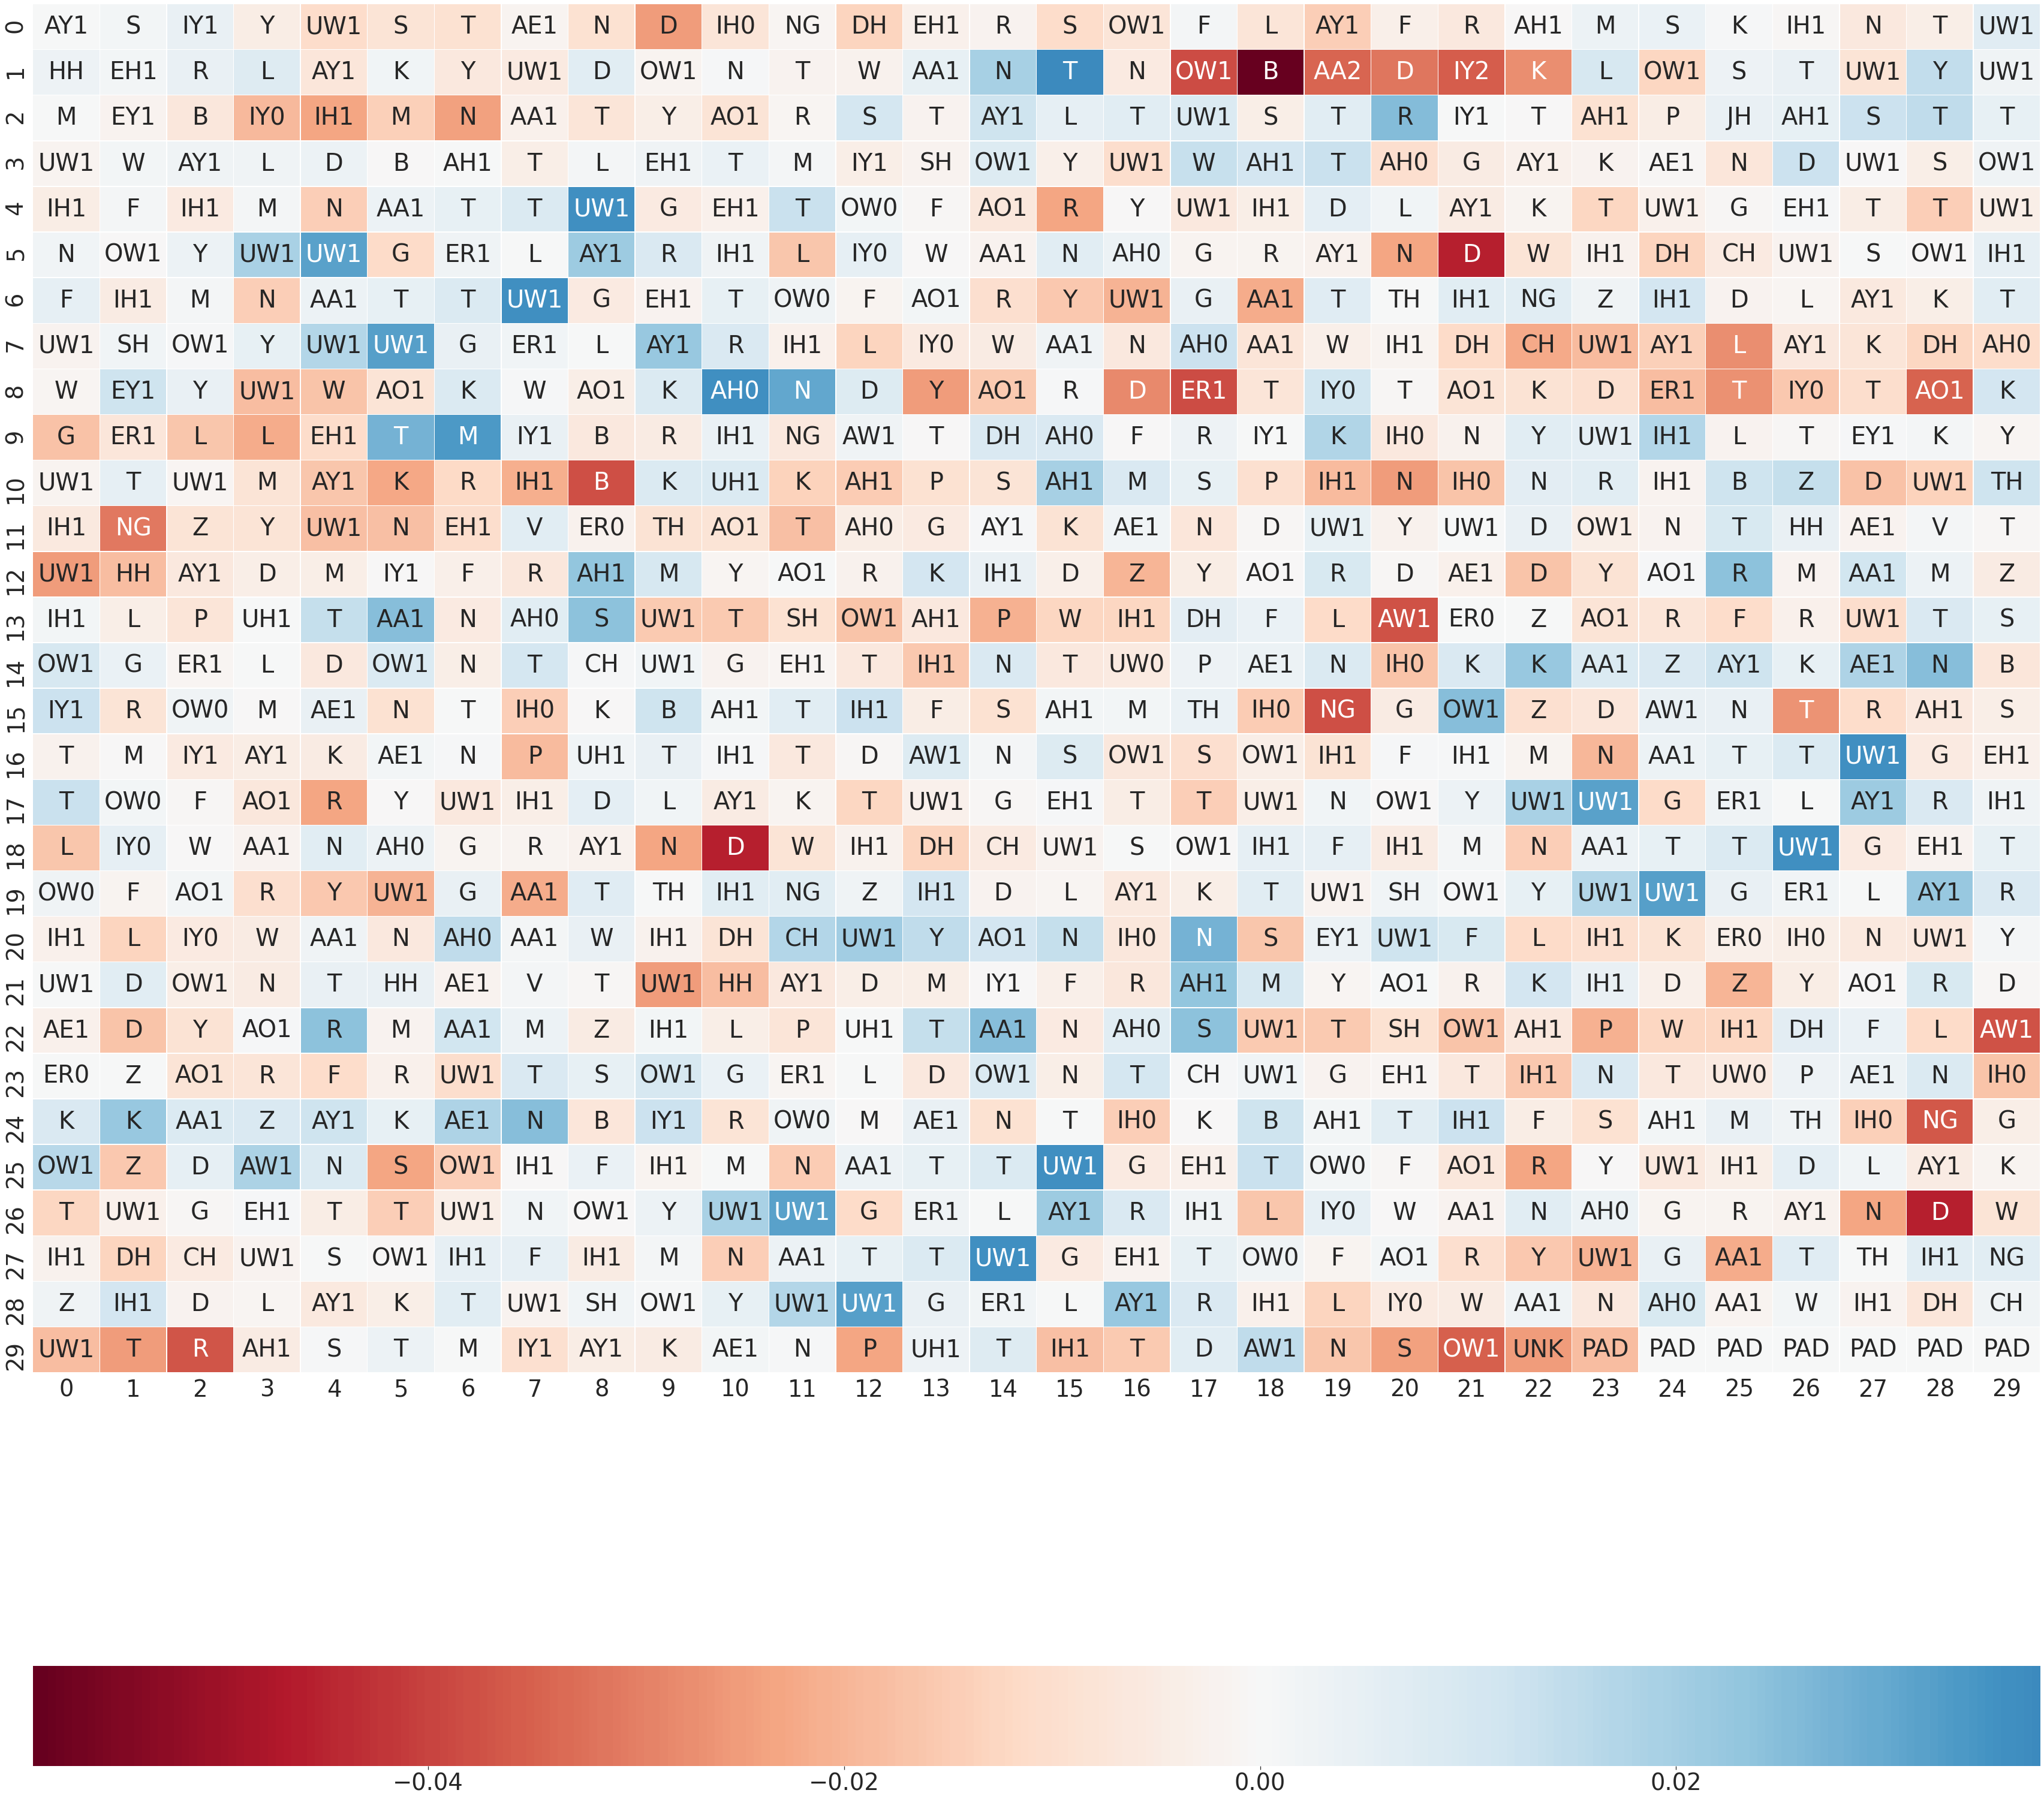

In [342]:
occluder_heatmap(analysis.loc[305,'Change List'], test_inputs[305], 'partial', 305)

**Another example, for a song whose lyrics has been splitted to phoneme sub-units for display purposes.**

In [11]:
splitted = [["|E","v","er","y","|n","igh","t","|I","k","ee","p","|p","r","ay","i","n'","|th","a","t","|y","ou","|l","o","ve","|m","e"],
["|E","v","er","y","|n","igh","t","|I","k","ee","p","|p","r","ay","i","n'","|th","a","t","|y","ou", "|d","o","-ooh"],
["|'C","au","se","|I", "|kn","ow","|th","a","t","|m","y","|l","i","fe","|w","oul","d","|b","e","|w","or","th","l","e","ss"],
["|W","i","th","ou","t","|y","ou","|W","i","th","ou","t","|y","ou","|W","i","th","ou","t","|y","ou","|W","i","th","ou","t","|y","ou","|W","i","th","ou","t","|y","ou"],
["|E","v","er","y","|n","igh","t","|I","k","ee","p","|p","r","ay","i","n'","|th","a","t","|y","ou","|w","a","n","t","|m","e"],
["|E","v","er","y","|n","igh","t","|I","k","ee","p","|p","r","ay","i","n'","|th","a","t","|y","ou", "|d","o","-ooh"],
["|'C","au","se","|I", "|kn","ow","|th","a","t","|m","y","|h","a","r","t","|w","oul","d","|b","e","|b","r","o","k","e","n"],
["|W","i","th","ou","t","|y","ou","|W","i","th","ou","t","|y","ou","|W","i","th","ou","t","|y","ou","|W","i","th","ou","t","|y","ou","|W","i","th","ou","t","|y","ou"],
["|I","|c","ou","ld","'","n","t","|b","ea","r","|t","o","|kn","ow","|y","ou","'d","|l","ea","ve","|m","e"],
["|D","o","dg","i","n'","|n","o","|n","o","|n","o","|n","o","|n","o"],
["|'C","au","se","|I", "|kn","ow","|th","a","t","|i","t","|w","oul","d","|g","r","ie","ve","|m","e"],
["|I","f","|y","ou", "|e","v","er","|g","o","|oh","|oh","|oh","|oh","|oh","|oh","|oh","|oh"],
["|E","v","er","y","|n","igh","t","|I","k","ee","p","|p","r","ay","i","n'","|th","a","t","|y","ou","|l","o","ve","|m","e"],
["|E","v","er","y","|n","igh","t","|i", "t","'s", "|th","e","|q","u","e","s","t","io","n","|th","a","t","|y","ou","|d","o","n","'t","|o","r","|d","o"],
["|S","o","|m","y","|l","o","ve", "|l","e","t", "|m","e","|kn","ow","|y","ou","|r","ea","ll","y","|l","o","ve","|y","e","s","|y","ou","|l","o","ve","|m","e"],
["|O","r","|i'","ll","|b","e","|o","r","|i'","ll","|b","e","|e","t","er","n","a","ll","y","|e","t","er","n","a","ll","y","|w","i","th","ou","t","|y","ou"],
["|oh","|oh","|oh","|oh","|oh","|oh"],
["|W","i","th","ou","t","|y","ou"],
["|F","a","de"]]
c = 0
for i in splitted:
    print(i,len(i))
    c+= len(i)
    


['|E', 'v', 'er', 'y', '|n', 'igh', 't', '|I', 'k', 'ee', 'p', '|p', 'r', 'ay', 'i', "n'", '|th', 'a', 't', '|y', 'ou', '|l', 'o', 've', '|m', 'e'] 26
['|E', 'v', 'er', 'y', '|n', 'igh', 't', '|I', 'k', 'ee', 'p', '|p', 'r', 'ay', 'i', "n'", '|th', 'a', 't', '|y', 'ou', '|d', 'o', '-ooh'] 24
["|'C", 'au', 'se', '|I', '|kn', 'ow', '|th', 'a', 't', '|m', 'y', '|l', 'i', 'fe', '|w', 'oul', 'd', '|b', 'e', '|w', 'or', 'th', 'l', 'e', 'ss'] 25
['|W', 'i', 'th', 'ou', 't', '|y', 'ou', '|W', 'i', 'th', 'ou', 't', '|y', 'ou', '|W', 'i', 'th', 'ou', 't', '|y', 'ou', '|W', 'i', 'th', 'ou', 't', '|y', 'ou', '|W', 'i', 'th', 'ou', 't', '|y', 'ou'] 35
['|E', 'v', 'er', 'y', '|n', 'igh', 't', '|I', 'k', 'ee', 'p', '|p', 'r', 'ay', 'i', "n'", '|th', 'a', 't', '|y', 'ou', '|w', 'a', 'n', 't', '|m', 'e'] 27
['|E', 'v', 'er', 'y', '|n', 'igh', 't', '|I', 'k', 'ee', 'p', '|p', 'r', 'ay', 'i', "n'", '|th', 'a', 't', '|y', 'ou', '|d', 'o', '-ooh'] 24
["|'C", 'au', 'se', '|I', '|kn', 'ow', '|th', 'a', 't', 

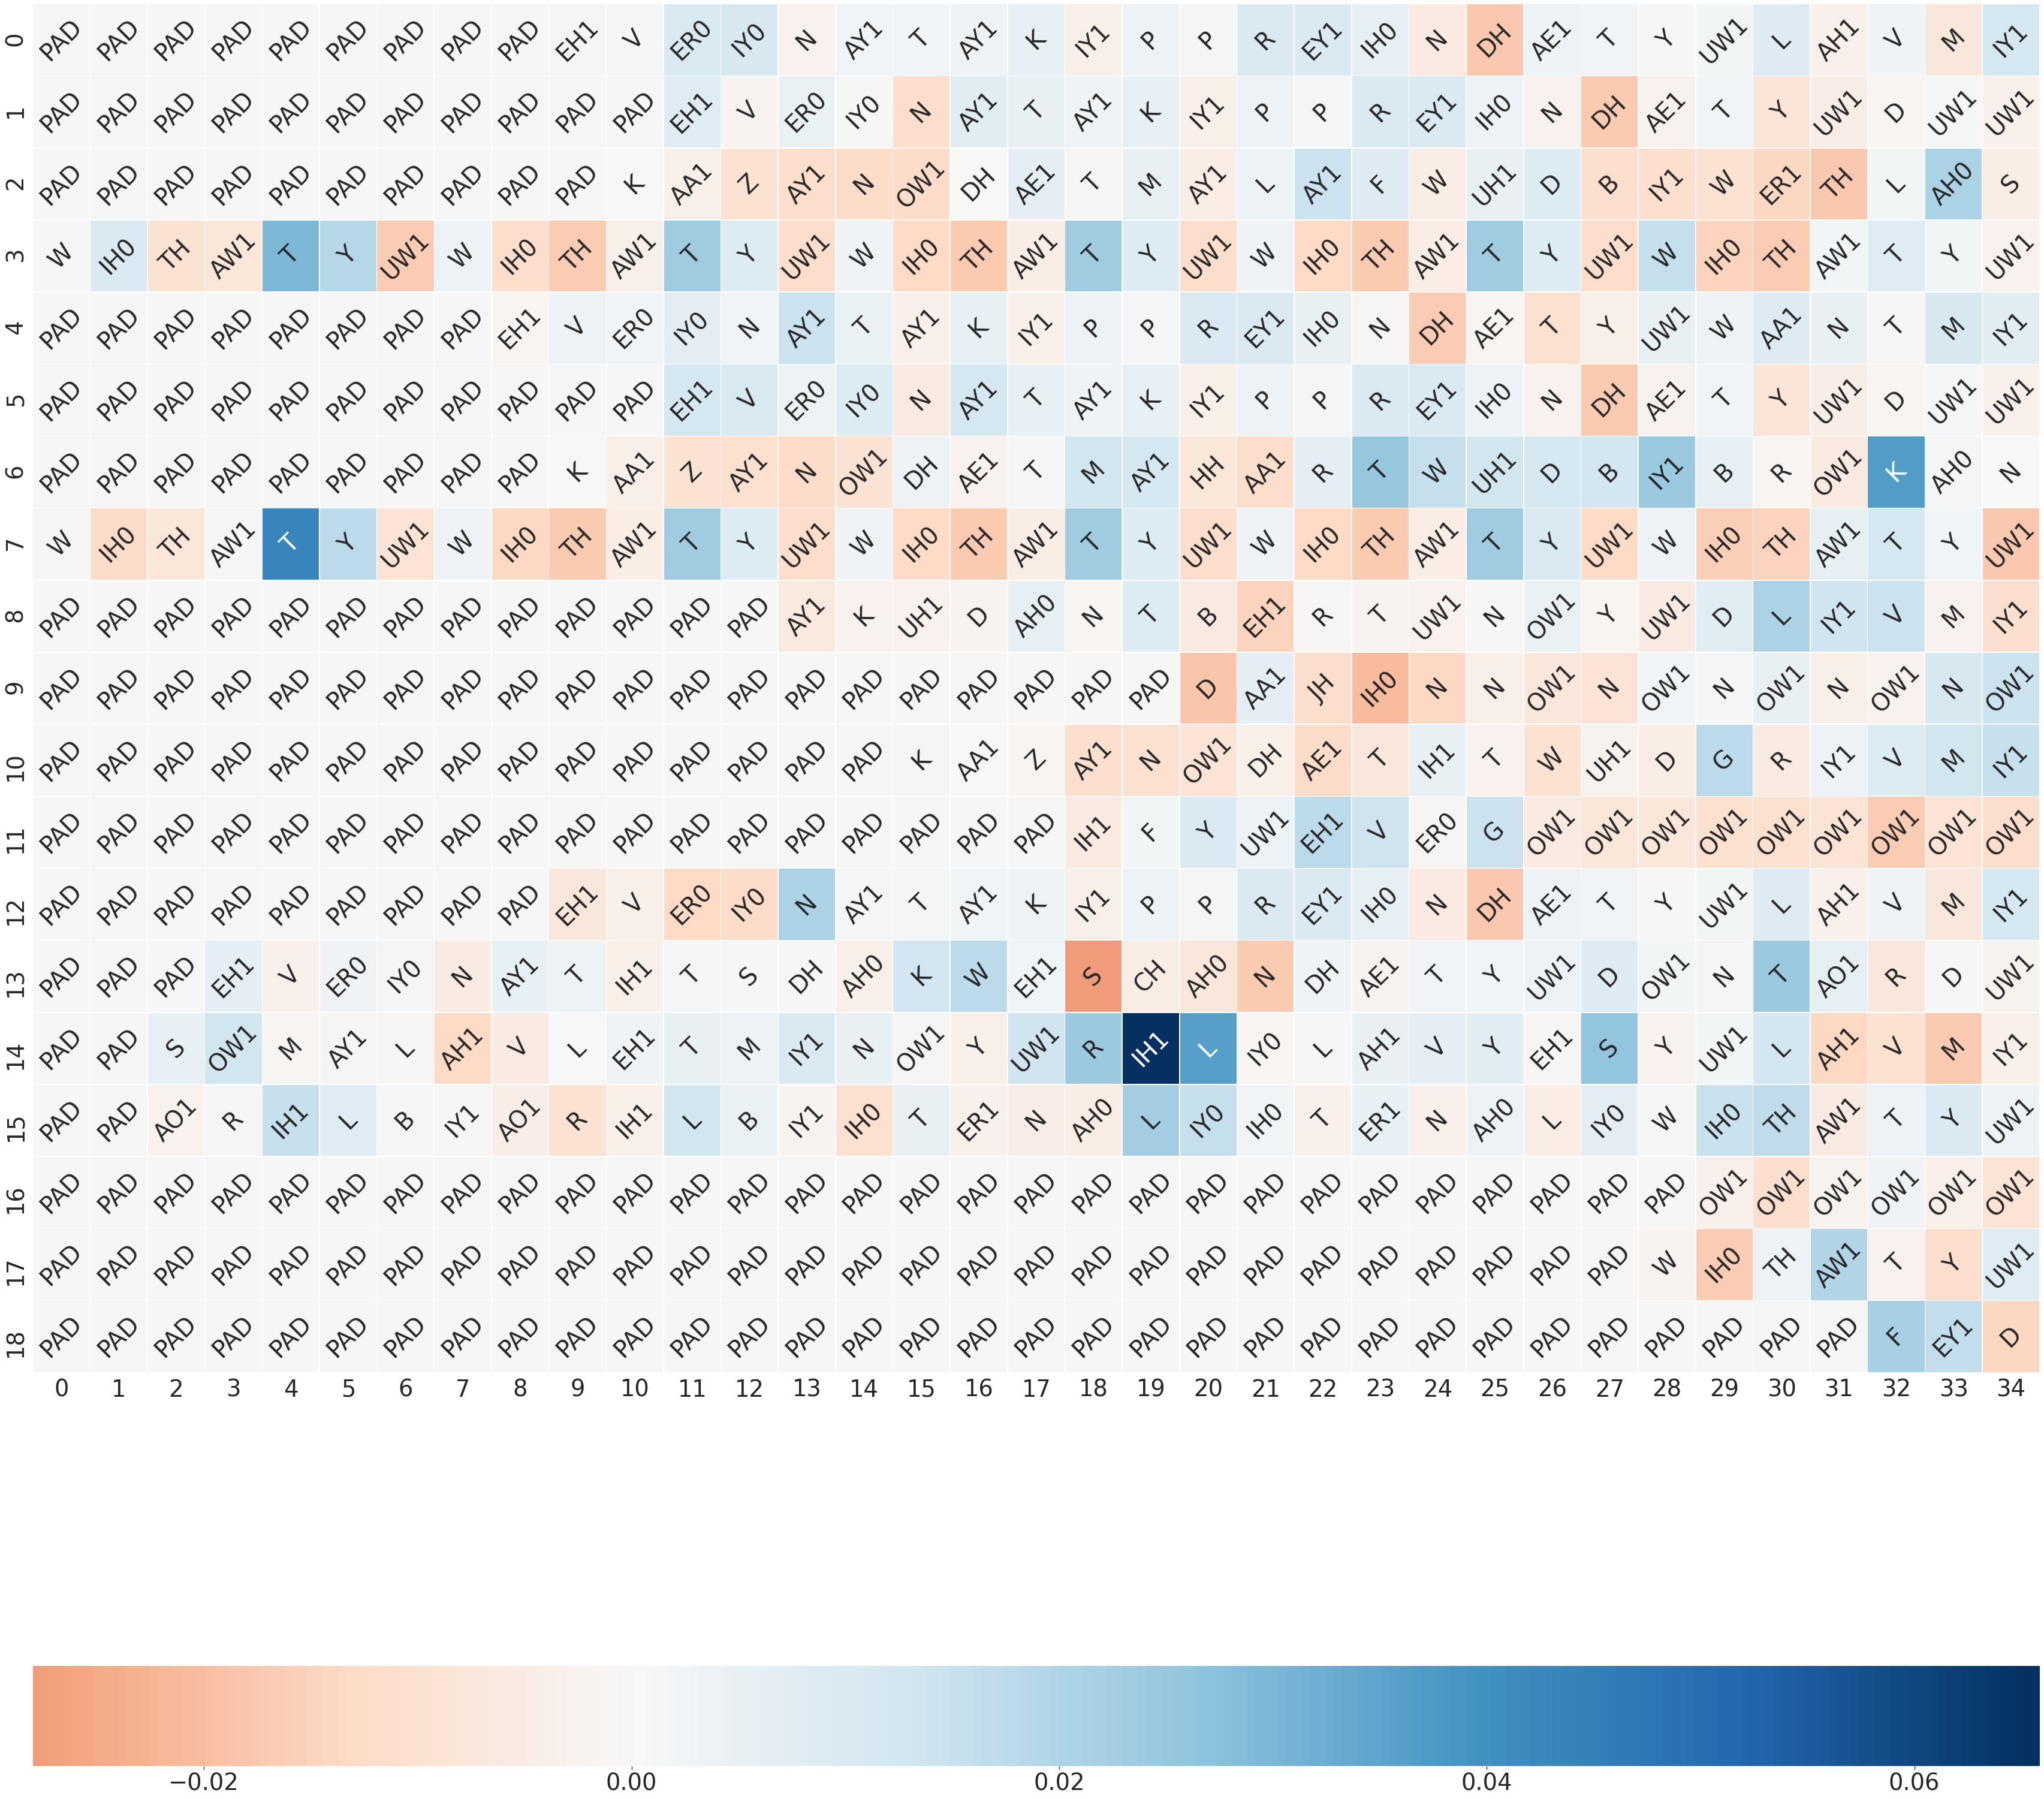

In [306]:
occluder_heatmap_wo_lyrics(analysis.loc[186,'Change List'], test_inputs[186], 'partial', 186, splitted)

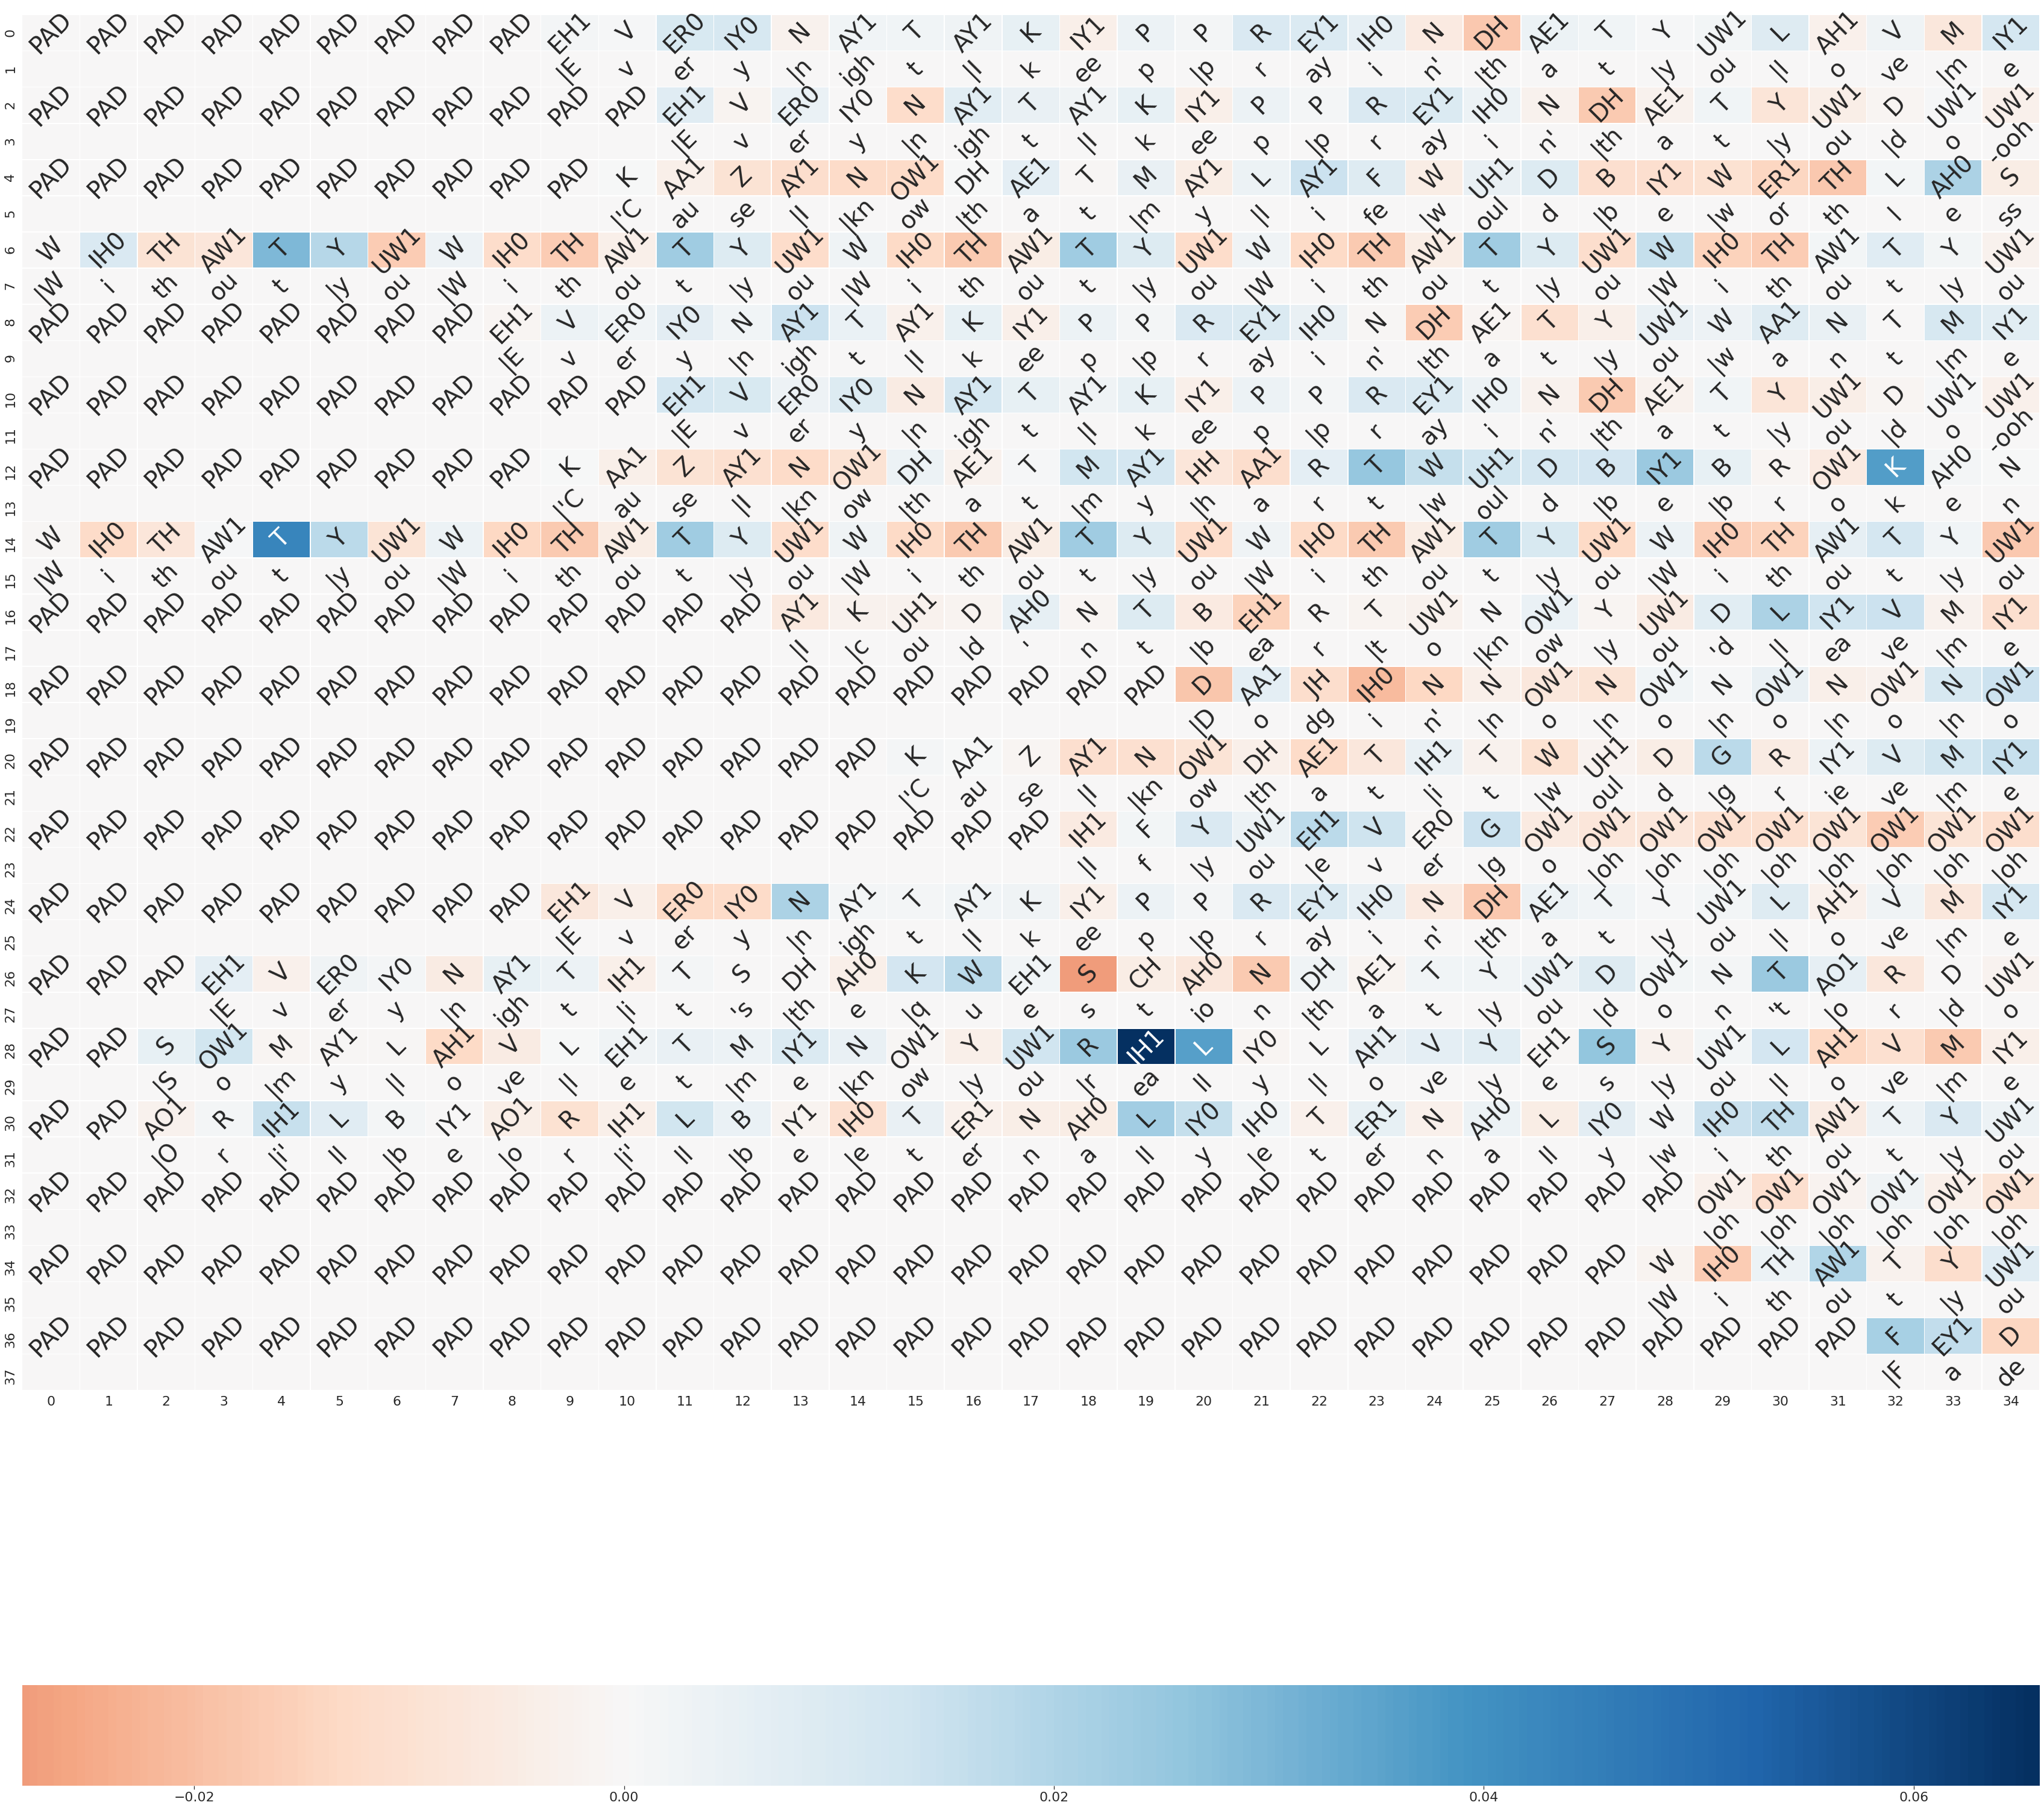

In [294]:
occluder_heatmap_w_lyrics(analysis.loc[186,'Change List'], test_inputs[186], 'partial', 186, splitted)

Some other examples if you have time

In [ ]:
occluder_heatmap(analysis.loc[40,'Change List'], test_inputs[40], 'partial', 40)

In [ ]:
occluder_heatmap(analysis.loc[213,'Change List'], test_inputs[213], 'partial', 213)

In [ ]:
occluder_heatmap(analysis.loc[152,'Change List'], test_inputs[152], 'partial', 152)